In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### **Settings**

In [168]:
img_size=96
batch_size=16

### **Dataset Source**

In [165]:
import pandas as pd
# Load CSV
csv_path = '/kaggle/input/plantclef/PlantCLEF2024singleplanttrainingdata.csv'
df = pd.read_csv(csv_path, sep=';', low_memory=False)

# Show the shape and first few rows
print(f"Shape: {df.shape}")
df.head()

Shape: (1408033, 20)


,image_name,organ,species_id,obs_id,license,partner,author,altitude,latitude,longitude,gbif_species_id,species,genus,family,dataset,publisher,references,url,learn_tag,image_backup_url
0,59feabe1c98f06e7f819f73c8246bd8f1a89556b.jpg,leaf,1396710,1008726402,cc-by-sa,NaN,Gulyás Bálint,205.9261,47.592160,19.362895,5284517.0,Taxus baccata L.,Taxus,Taxaceae,plantnet,plantnet,https://identify.plantnet.org/fr/k-southwester...,https://bs.plantnet.org/image/o/59feabe1c98f06...,train,https://lab.plantnet.org/LifeCLEF/PlantCLEF202...
1,dc273995a89827437d447f29a52ccac86f65476e.jpg,leaf,1396710,1008724195,cc-by-sa,NaN,vadim sigaud,323.7520,47.906703,7.201746,5284517.0,Taxus baccata L.,Taxus,Taxaceae,plantnet,plantnet,https://identify.plantnet.org/fr/k-southwester...,https://bs.plantnet.org/image/o/dc273995a89827...,train,https://lab.plantnet.org/LifeCLEF/PlantCLEF202...
2,416235e7023a4bd1513edf036b6097efc693a304.jpg,leaf,1396710,1008721908,cc-by-sa,NaN,fil escande,101.3160,48.826774,2.352774,5284517.0,Taxus baccata L.,Taxus,Taxaceae,plantnet,plantnet,https://identify.plantnet.org/fr/k-southwester...,https://bs.plantnet.org/image/o/416235e7023a4b...,train,https://lab.plantnet.org/LifeCLEF/PlantCLEF202...
3,cbd18fade82c46a5c725f1f3d982174895158afc.jpg,leaf,1396710,1008699177,cc-by-sa,NaN,Desiree Verver,5.1070,52.190427,6.009677,5284517.0,Taxus baccata L.,Taxus,Taxaceae,plantnet,plantnet,https://identify.plantnet.org/fr/k-southwester...,https://bs.plantnet.org/image/o/cbd18fade82c46...,train,https://lab.plantnet.org/LifeCLEF/PlantCLEF202...
4,f82c8c6d570287ebed8407cefcfcb2a51eaaf56e.jpg,leaf,1396710,1008683100,cc-by-sa,NaN,branebrane,165.3390,45.794739,15.965862,5284517.0,Taxus baccata L.,Taxus,Taxaceae,plantnet,plantnet,https://identify.plantnet.org/fr/k-southwester...,https://bs.plantnet.org/image/o/f82c8c6d570287...,train,https://lab.plantnet.org/LifeCLEF/PlantCLEF202...


### **Preprocess Dataset - One Image One Plant**

In [169]:

#--------------------------------------------------------
# Filter data to be more focused to 5 families with only 1 organ

# Drop rows without a valid 'family'
df = df.dropna(subset=['image_backup_url', 'family']).reset_index(drop=True)

# Count frequency of each family
family_counts = df['family'].value_counts()

# Select top 5 most common families
top_families = family_counts.head(5).index.tolist()

# Filter dataset to only include those families, and only 1 organ
df = df[df['family'].isin(top_families)].reset_index(drop=True)
df = df[df['organ'] == 'flower'].reset_index(drop=True)

#---------------------------------------------------------------
# Manage Labels
# Create new label mappings based on the 5 families
label_to_idx = {fam: i for i, fam in enumerate(sorted(df['family'].unique()))}

# Add new column in dataframe - "label"; Map family to integer label
df['label'] = df['family'].map(label_to_idx).astype(int)

#-----------------------------------------------------------------------
# Split dataset into Train and Validation Set

from sklearn.model_selection import train_test_split

# df is your full dataframe
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['label'],  # This keeps class proportions
    random_state=42
)



#------------------------------------------------------

In [170]:
# Sanity check
print(f"Total samples after filtering: {len(df)}")
print(f"Unique families: {df['family'].unique()}")
print("Number of samples per family:")
print(df['family'].value_counts())
print("")

print("Training label distribution:")
print(train_df['label'].value_counts(normalize=True))
print("")


print(f"Training samples after filtering: {len(train_df)}")
print(f"Unique families: {train_df['family'].unique()}")
print("Number of samples per family:")
print(train_df['family'].value_counts())

print("\nValidation label distribution:")
print(val_df['label'].value_counts(normalize=True))


print(f"Validation samples after filtering: {len(val_df)}")
print(f"Unique families: {val_df['family'].unique()}")
print("Number of samples per family:")
print(val_df['family'].value_counts())

Total samples after filtering: 130259
Unique families: ['Rosaceae' 'Fabaceae' 'Asteraceae' 'Poaceae' 'Brassicaceae']
Number of samples per family:
family
Asteraceae      54269
Fabaceae        28782
Brassicaceae    16189
Poaceae         16177
Rosaceae        14842
Name: count, dtype: int64

Training label distribution:
label
0    0.416623
2    0.220954
1    0.124281
3    0.124195
4    0.113946
Name: proportion, dtype: float64

Training samples after filtering: 104207
Unique families: ['Asteraceae' 'Brassicaceae' 'Fabaceae' 'Poaceae' 'Rosaceae']
Number of samples per family:
family
Asteraceae      43415
Fabaceae        23025
Brassicaceae    12951
Poaceae         12942
Rosaceae        11874
Name: count, dtype: int64

Validation label distribution:
label
0    0.416628
2    0.220981
1    0.124290
3    0.124175
4    0.113926
Name: proportion, dtype: float64
Validation samples after filtering: 26052
Unique families: ['Asteraceae' 'Poaceae' 'Brassicaceae' 'Fabaceae' 'Rosaceae']
Number of sampl

In [171]:
from PIL import Image
import requests
from io import BytesIO

class PlantClefDataset(torch.utils.data.Dataset):
    def __init__(self, df = df, transform=None , label_to_idx = label_to_idx):
        self.df = df
        self.df = df.reset_index(drop=True)
        
        self.transform = transform

        # Create new label mappings based on the 5 families
        self.label_to_idx = label_to_idx
        self.idx_to_label = {i: fam for fam, i in label_to_idx.items()}
        self.num_classes = len(self.label_to_idx)
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        url = self.df.loc[idx, 'url']
        label = self.df.loc[idx, 'label']

        try:
            response = requests.get(url, timeout=10)
            image = Image.open(BytesIO(response.content)).convert('RGB')
        except:
            # Return a blank image if loading fails
            image = Image.new('RGB', (224, 224), (255, 255, 255))

        if self.transform:
            image = self.transform(image)

        # Convert integer label to one-hot encoded vector
        label_onehot = torch.zeros(self.num_classes)
        label_onehot[label] = 1.0

        return image, label_onehot


#--------------------------------------------------------------------------------------------------
from torchvision import transforms

plant_transform = transforms.Compose([
    transforms.Resize((img_size,img_size)),
    transforms.ToTensor(),  # Scales to [0, 1]

])


Number of classes in Training: 5
Classes: {'Asteraceae': 0, 'Brassicaceae': 1, 'Fabaceae': 2, 'Poaceae': 3, 'Rosaceae': 4}
Total samples after filtering: 104207
Unique families: ['Asteraceae' 'Brassicaceae' 'Fabaceae' 'Poaceae' 'Rosaceae']
Number of samples per family:
family
Asteraceae      43415
Fabaceae        23025
Brassicaceae    12951
Poaceae         12942
Rosaceae        11874
Name: count, dtype: int64
Number of classesin Validation: 5
Classes: {'Asteraceae': 0, 'Brassicaceae': 1, 'Fabaceae': 2, 'Poaceae': 3, 'Rosaceae': 4}
Total samples after filtering: 26052
Unique families: ['Asteraceae' 'Poaceae' 'Brassicaceae' 'Fabaceae' 'Rosaceae']
Number of samples per family:
family
Asteraceae      10854
Fabaceae         5757
Brassicaceae     3238
Poaceae          3235
Rosaceae         2968
Name: count, dtype: int64


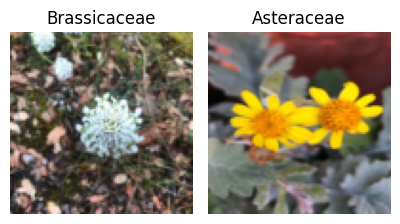

In [172]:
# Checks - check if Class work properly

plant_train = PlantClefDataset(train_df, transform=plant_transform)
plant_val  = PlantClefDataset(val_df, transform=plant_transform)

train_loader = DataLoader(plant_train, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(plant_val, batch_size=batch_size, shuffle=False, num_workers=0)

# Checks
print(f"Number of classes in Training: {plant_train.num_classes}")
print("Classes:", plant_train.label_to_idx)

print(f"Total samples after filtering: {len(plant_train.df)}")
print(f"Unique families: {plant_train.df['family'].unique()}")
print("Number of samples per family:")
print(plant_train.df['family'].value_counts())

print(f"Number of classesin Validation: {plant_val.num_classes}")
print("Classes:", plant_val.label_to_idx)

print(f"Total samples after filtering: {len(plant_val.df)}")
print(f"Unique families: {plant_val.df['family'].unique()}")
print("Number of samples per family:")
print(plant_val.df['family'].value_counts())


# check if image can be loaded
import matplotlib.pyplot as plt

images, labels = next(iter(train_loader))

plt.figure(figsize=(12, 4))
for i in range(2):
    #img = images[i].permute(1, 2, 0) * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
    img = images[i].permute(1, 2, 0).numpy()  
    plt.subplot(1, 6, i+1)
    plt.imshow(img)
    plt.title(plant_train.idx_to_label[labels[i].argmax().item()])  #convert one hot label to value label
    plt.axis('off')


plt.subplots_adjust(wspace=0.5)  # add spacing between images
plt.tight_layout()
plt.show()


### **Preprocess Dataset - Prepare Quadrat Images for Training and Validation**

In [173]:
from torch.utils.data import Dataset
from PIL import Image
import torch
import random

class QuadratDataset(Dataset):
    def __init__(self, base_dataset, quad_size=4, transform=None):
        self.base = base_dataset
        self.quad_size = quad_size  # e.g. 4 for 2x2 grid
        self.transform = transform
        self.num_classes = self.base.num_classes

    def __len__(self):
        return len(self.base) // self.quad_size

    def __getitem__(self, idx):
        imgs, labels = [], []

        for _ in range(self.quad_size):
            # Randomly select a single-plant image and its one-hot label
            img, lbl = self.base[random.randint(0, len(self.base) - 1)]
            imgs.append(transforms.ToPILImage()(img))  # Convert back to PIL for stitching
            labels.append(lbl)

        # Assume all images same size, create blank 2x2 canvas
        w, h = imgs[0].size
        quad = Image.new('RGB', (w*2, h*2))

        coords = [(0, 0), (w, 0), (0, h), (w, h)]
        for img_patch, xy in zip(imgs, coords):
            quad.paste(img_patch, xy)

        if self.transform:
            quad = self.transform(quad)

        # Multi-label target (merge all 4 labels)
        ml_label = torch.zeros(self.num_classes)
        for lbl in labels:
            ml_label = torch.logical_or(ml_label, lbl.bool()).float()

        return quad, ml_label


quadrat_transform = transforms.Compose([
    transforms.Resize((img_size,img_size)),
    transforms.ToTensor(),  # Scales to [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [174]:
# Create single-plant datasets
train_base = PlantClefDataset(train_df, transform=plant_transform)
val_base = PlantClefDataset(val_df, transform=plant_transform)

# Create quadrat datasets for training and validation
quadrat_train = QuadratDataset(train_base, quad_size=4, transform=quadrat_transform)
quadrat_val = QuadratDataset(val_base, quad_size=4, transform=quadrat_transform)

train_loader = DataLoader(quadrat_train, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(quadrat_val, batch_size=16, shuffle=False, num_workers=4)

In [175]:
# Checks
print(f"Total samples in quadrat_test: {len(quadrat_train)}")
print(f"Total samples in quadrat_test: {len(quadrat_val)}")

Total samples in quadrat_test: 26051
Total samples in quadrat_test: 6513


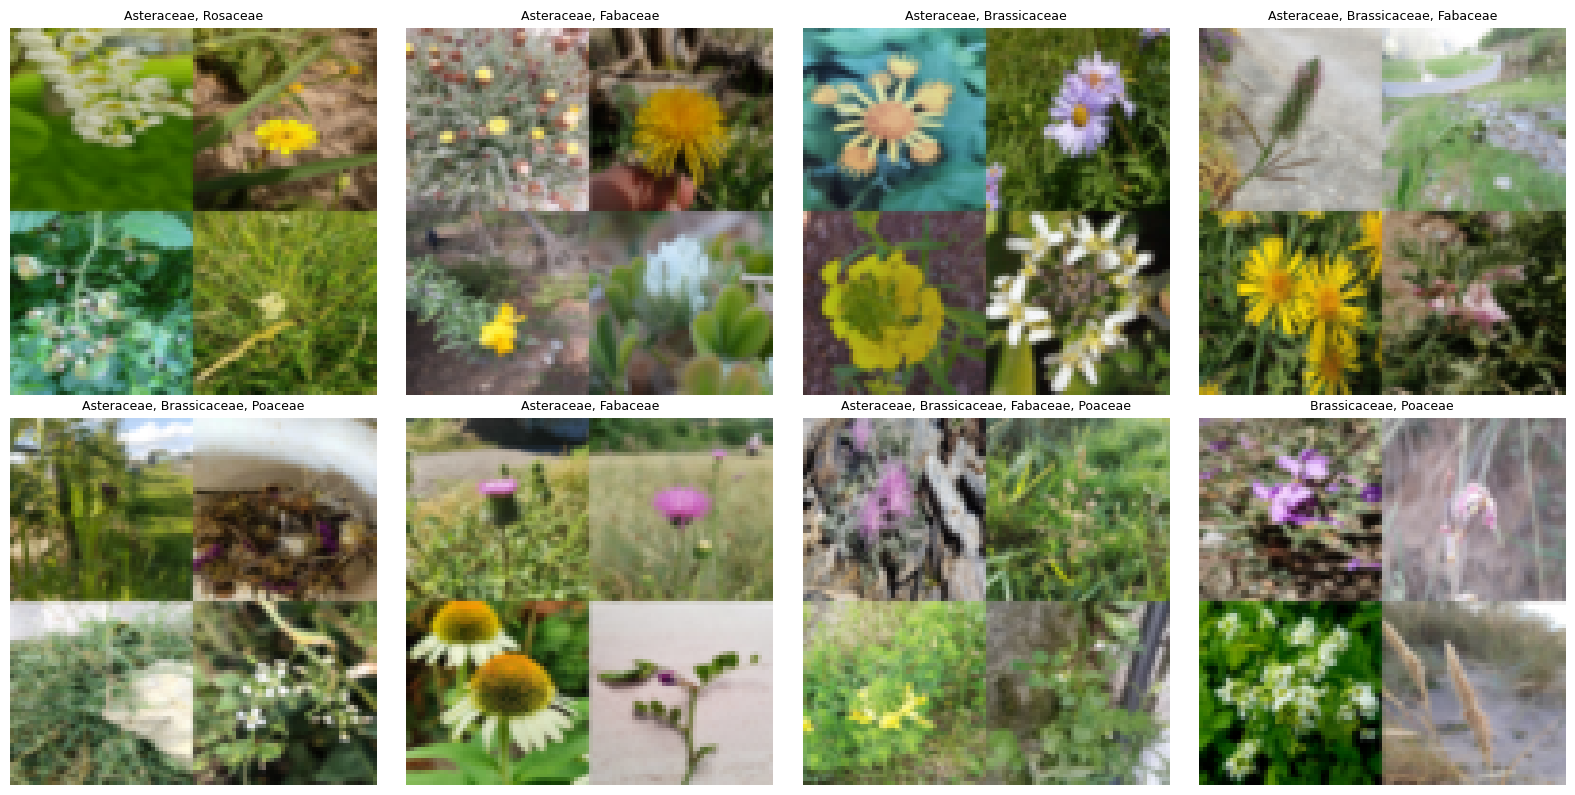

In [176]:
# Checks
import matplotlib.pyplot as plt
import torchvision

# Get one batch from the training loader
images, labels = next(iter(train_loader))  # or val_loader

# De-normalize helper (reverse normalization)
def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1,1,3)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1,1,3)
    return tensor * std + mean

# Plot the first few images with labels
plt.figure(figsize=(16, 8))
for i in range(8):  # Show 8 samples
    img = images[i].permute(1, 2, 0).detach().cpu()  # CHW -> HWC
    img = denormalize(img).numpy()
    img = np.clip(img, 0, 1)

    # Get label indices
    label_idxs = torch.nonzero(labels[i]).squeeze().tolist()
    if isinstance(label_idxs, int): label_idxs = [label_idxs]

    # Convert label indices to family names
    label_names = [train_loader.dataset.base.idx_to_label[idx] for idx in label_idxs]

    plt.subplot(2, 4, i+1)
    plt.imshow(img)
    plt.title(", ".join(label_names), fontsize=9)
    plt.axis('off')

plt.tight_layout()
plt.show()


# **Model**